# Start

In [ ]:
# this is the source for the database.
# URL = 'https://www.kaggle.com/datasets/alessiocorrado99/animals10'

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from PIL import Image
from glob import glob
import random
import os
import cv2
from pathlib import Path
from keras.applications.vgg16 import preprocess_input
from google.colab import files
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.applications import VGG16

In [ ]:
# muonting to google drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/פרוייקט סיכום הנדסת תוכנה/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = tf.keras.models.load_model(path+'/model.keras')

In [ ]:
# calculate intersection over union
def localization_iou(y_true, y_pred):

    y_true = y_true.copy() #make a copy
    y_pred = y_pred.copy()

    y_true[:,2] +=y_true[:,0] #calculate y-high coordinate
    y_true[:,3] +=y_true[:,1] #calculate x-high coordinate

    y_pred[:,2] +=y_pred[:,0] #calculate y-high coordinate
    y_pred[:,3] +=y_pred[:,1] #calculate x-high coordinate

    # Calculate the coordinates of the intersection rectangle
    x_min = np.max([y_true[:, 0], y_pred[:,0]], axis=0)
    y_min = np.max([y_true[:, 1], y_pred[:, 1]], axis=0)
    x_max = np.min([y_true[:, 2], y_pred[:, 2]], axis=0)
    y_max = np.min([y_true[:, 3], y_pred[:, 3]], axis=0)

    # Calculate the area of intersection rectangle
    a = x_max - x_min
    b = y_max - y_min

    a = a * (a >= 0)
    b = b * (b >= 0)

    intersection_area = a * b

    # Calculate the area of the union rectangle
    y_true_area = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    y_pred_area = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])
    union_area = y_true_area + y_pred_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 224, 224, 3)          0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                                                                                              

In [ ]:
cat_eng = {'chicken': 0, 'squirrel': 1, 'cow': 2, 'horse': 3, 'sheep': 4, 'cat': 5,
           'elephant': 6, 'dog': 7, 0: 'chicken', 1: 'squirrel', 2: "cow", 3: 'horse',
           4: 'sheep', 5: 'cat', 6: 'elephant', 7: 'dog'}

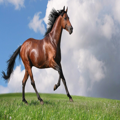

In [ ]:
horse = Image.open(path + "horse.jpg")
horse = horse.resize(size=(120, 120))
# horse = np.array(horse)
# horse = np.expand_dims(horse, axis=0)
# horse = preprocess_input(horse)
horse
# horse = model.predict(horse)

In [ ]:
# backgrounds
!wget -q 'https://raw.githubusercontent.com/arielb30/pokemon/main/backgrounds.zip'
!unzip -q -n backgrounds.zip

In [ ]:
backgrounds = []
background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # open and resize backgrounds
  bg = Image.open(f).resize((224, 224))  # images are originally shaped 224 by 350 ish
  backgrounds.append(np.array(bg))

In [ ]:
print(len(backgrounds))

15


In [ ]:
h = np.array(horse)
b = np.array(backgrounds[0])

print(h.shape)
print(b.shape)

(120, 120, 3)
(224, 224, 3)


# Working Functions

In [ ]:

def print_image_to_background(image, shape=(40, 40), bg=0):

  if bg > len(backgrounds)-1:
    bg = 0

  loc = [shape[0], shape[1]]
  if loc[0] < 0:
    loc[0] = 0

  if loc[1] < 0:
    loc[1] = 0

  if loc[0] > 100:
    loc[0] = 100

  if loc[1] > 100:
    loc[1] = 100

  bg = np.array(backgrounds[bg])

  img = np.array(image)

  if img.shape[0] > 120:
    image = image.resize((img.shape[1], 120))

  img = np.array(image)

  if img.shape[1] > 120:
    image = image.resize((120, img.shape[0]))

  img = np.array(image)

  bg[loc[1]:loc[1]+img.shape[1], loc[0]:loc[0]+img.shape[0]] = img

  print(bg.shape)

  return Image.fromarray(bg)



(224, 224, 3)


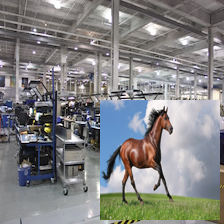

In [ ]:
a = print_image_to_background(horse, (130, 130), bg=5)
a

In [ ]:
def predict_image(image):
  image = np.array(image)
  im = image.copy()
  im = im.reshape(1, im.shape[0], im.shape[1], im.shape[2])
  (pred_bbox, pred_cat) = model.predict(im)
  print(pred_bbox.shape, pred_cat.shape)
  return (pred_bbox, pred_cat, image)


In [ ]:
(pb, pc, img) = predict_image(print_image_to_background(horse, (130, 130), bg=5))

(224, 224, 3)
1/1 [==============================] - 1s 694ms/step
(1, 4) (1, 8)


In [ ]:
def return_result(pb, pc, img):

  ax = plt.subplot(1, 1, 1)
  ax.imshow(img.astype(np.uint8))

  size = 224

  rect = Rectangle(
      (pb[0,1]* 224, pb[0,0]* 224),
      pb[0,3]* 224, pb[0,2]* 224,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

  p_cat = np.argmax(pc[0])
  print(p_cat, cat_eng[p_cat])
  return ax

(224, 224, 3)
1/1 [==============================] - 1s 554ms/step
(1, 4) (1, 8)
3 horse


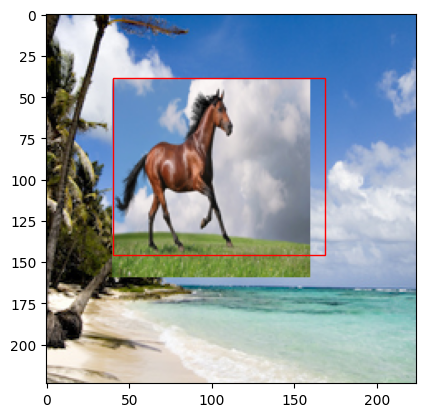

In [ ]:

horse = Image.open(path + "horse.jpg")
img = print_image_to_background(horse)
(pb, pc, img) = predict_image(img)

im = return_result(pb, pc, img)



3 horse


<Axes: >

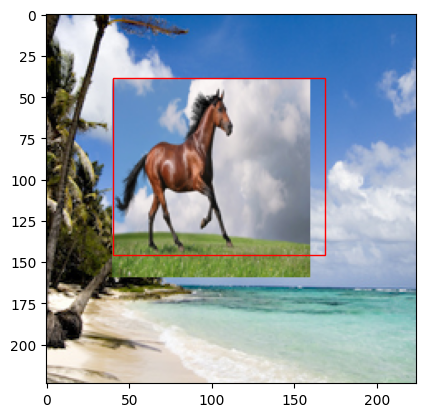

In [ ]:
return_result(pb, pc, img)

In [ ]:
horse = Image.open(path + "horse.jpg")
h = np.array(horse)
print(h.shape)

horse = horse.resize((250, 120))
h = np.array(horse)
print(h.shape)


(1086, 1926, 3)
(120, 250, 3)


In [ ]:


horse = Image.open(path + "horse.jpg")


def work_all(im, loca=(30, 30), bag=0):
  img = print_image_to_background(im, shape=loca, bg=bag)

  (pb, pc, img) = predict_image(img)

  ax = return_result(pb, pc, img)
  plt.savefig("product.png")
  return ax, pc

(224, 224, 3)
1/1 [==============================] - 1s 920ms/step
(1, 4) (1, 8)
3 horse


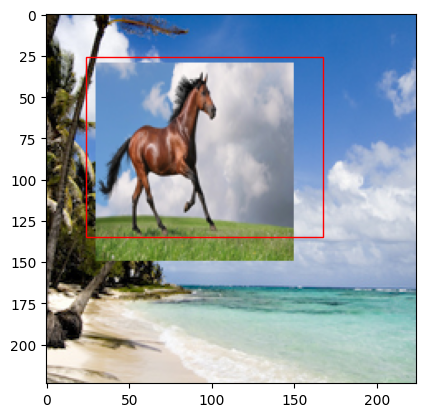

In [ ]:
ax, cat = work_all(horse)

In [ ]:
!pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
import anvil.server
import anvil.media

In [ ]:
# Anvil connection

@anvil.server.callable
def classify_image(file, loc=(50, 50), bagr=0):
  with anvil.media.TempFile(file) as f:
    img = tf.keras.utils.load_img(f)

  ax, cat = work_all(img, loca=loc, bag=bagr)

  cat = cat_eng[np.argmax(cat)]

  im = anvil.media.from_file("product.png")
  return im, cat


In [ ]:
anvil.server.connect("server_HGCZL633GOSHSYMKNBS43U57-GPSK432H4S7M2CQJ")

(224, 224, 3)
1/1 [==============================] - 1s 537ms/step
(1, 4) (1, 8)
4 sheep


KeyboardInterrupt: 

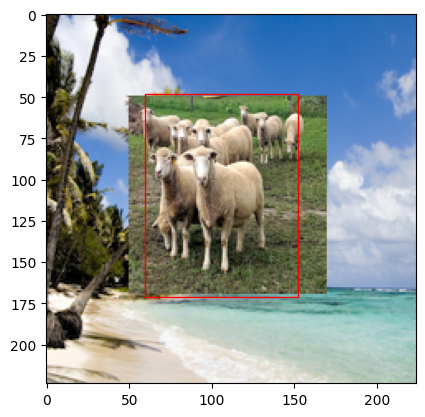

In [ ]:
anvil.server.wait_forever()